In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from tabpfn import TabPFNClassifier, TabPFNRegressor
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import cross_val_score, LeaveOneOut, StratifiedKFold
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, roc_auc_score, r2_score, mean_absolute_error, mean_squared_error, cohen_kappa_score
import matplotlib.pyplot as plt
import warnings

In [2]:
warnings.filterwarnings('ignore', category=UserWarning)

# Load Data

In [3]:
sensor_data = pd.read_csv('./results.csv', index_col=0)
sensor_data = sensor_data[sensor_data['ID'] != 11024].reset_index(drop=True) # Wearing time less then 1 hour
sensor_data = sensor_data[sensor_data['ID'] != 12001].reset_index(drop=True) # Incorrect sensor orientation

sa_data = pd.read_excel('./SAh_OKIE_DB_20250303.xlsx', sheet_name=0, header=0, engine='openpyxl')
sa_data = sa_data.rename(columns={'id': 'ID'})

In [4]:
catalog = pd.read_csv('./catalog.csv')
lumbar_ID = catalog[catalog.sensor_attachment_su=='lumbar'].ID.values.tolist()
sa_data = sa_data[sa_data['ID'].isin(lumbar_ID)]

## Remove algorithmic data

In [5]:
sensor_data = sensor_data[sensor_data.columns[:62]]

## Preprocess Data

In [6]:
sensor_data['root_mean_square_vector_magnitude'] = np.sqrt(
    sensor_data['root_mean_square_x'] ** 2 + 
    sensor_data['root_mean_square_y'] ** 2 + 
    sensor_data['root_mean_square_z'] ** 2
)

In [7]:
sensor_data['detail_power_vector_magnitude'] = np.sqrt(
    sensor_data['detail_power_x'] ** 2 + 
    sensor_data['detail_power_y'] ** 2 + 
    sensor_data['detail_power_z'] ** 2
)

In [8]:
sensor_data['power_spectral_sum_vector_magnitude'] = np.sqrt(
    sensor_data['power_spectral_sum_x'] ** 2 + 
    sensor_data['power_spectral_sum_y'] ** 2 + 
    sensor_data['power_spectral_sum_z'] ** 2
)

# Analysis

In [9]:
def bootstrap(y, y_pred, metric, **kwargs):
    results = []
    for _ in range(1000):
        sample_A, sample_B = resample(y, y_pred)
        res = metric(sample_A, sample_B, **kwargs)
        results.append(res)
    ci_lower = np.percentile(results, 2.5)
    ci_upper = np.percentile(results, 97.5)
    return ci_lower, ci_upper

## Continuity of Care

In [10]:
sa_discharge = sa_data.dropna(subset='dis_geriatrician_0').copy()
sensor_discharge = sensor_data[sensor_data['ID'].isin(sa_discharge['ID'])].copy()

coc_mapping = {
    0: 'Back Home',
    1: 'Nursing Home',
    2: 'Nursing Home',
    3: 'Rehabilitation',
    4: 'Rehabilitation',
    5: 'Acute Geriatric Care Unit',
    6: np.nan
}

sa_discharge.loc[:, 'coc_ground_truth'] = sa_discharge.loc[:, 'dis_geriatrician_0'].map(coc_mapping)
coc = pd.merge(sensor_discharge, sa_discharge[['ID', 'coc_ground_truth']], on='ID', how='left')

In [11]:
results = []
variables = ['mean_x', 'mean_y', 'mean_z']
groups = coc['coc_ground_truth'].unique()

for group in groups:
    group_data = coc[coc['coc_ground_truth'] == group]
    rest_data = coc[coc['coc_ground_truth'] != group]
    
    row = {'Group': group}
    
    for var in variables:
        mean_val = group_data[var].mean()
        std_val = group_data[var].std()
        row[f'{var}_mean'] = mean_val
        row[f'{var}_std'] = std_val
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning) # Rehabiliaiton has only 1 sample
            t_stat, p_val = stats.ttest_ind(group_data[var], rest_data[var], equal_var=False, nan_policy='omit')
        row[f'{var}_pval'] = p_val

    results.append(row)

pd.DataFrame(results)

,Group,mean_x_mean,mean_x_std,mean_x_pval,mean_y_mean,mean_y_std,mean_y_pval,mean_z_mean,mean_z_std,mean_z_pval
0,Acute Geriatric Care Unit,0.313707,0.096645,0.444082,-0.066242,0.169336,0.097514,0.864162,0.111776,0.000016
1,Back Home,0.344219,0.167700,0.543155,0.034011,0.185952,0.087021,0.569479,0.250992,0.000085
2,Rehabilitation,0.387914,NaN,NaN,-0.041547,NaN,NaN,0.575990,NaN,NaN


### Kruskal-Wallis

In [12]:
def get_kruskal(df, target):
    results = pd.DataFrame()
    
    for col in df.columns[1:-1]:
        df_clean = df.dropna(subset=[col])
        unique_classes = df_clean[target].unique()
        groups = [df_clean[df_clean[target] == c][col] for c in unique_classes]
        groups = [group if not group.empty else pd.Series(np.nan, dtype=float) for group in groups]
        h_stat, p_val = stats.kruskal(*groups)
        for group in unique_classes:
            results.loc[col, [f'{group}']] = df_clean.loc[df[target]==group, col].mean()
        results.loc[col, 'p_value'] = p_val

    return results

In [13]:
coc_table = get_kruskal(coc, 'coc_ground_truth')
features = coc_table.loc[coc_table['p_value']<0.05, 'p_value']
features.round(4)

mean_z                                 0.0003
standard_deviation_x                   0.0389
standard_deviation_y                   0.0055
standard_deviation_z                   0.0000
skewness_z                             0.0006
kurtosis_z                             0.0003
interquartile_range_z                  0.0013
mean_cross_rate_z                      0.0022
autocorrelation_z                      0.0235
signal_entropy_y                       0.0089
root_mean_square_x                     0.0389
root_mean_square_y                     0.0055
root_mean_square_z                     0.0000
detail_power_y                         0.0040
power_spectral_sum_x                   0.0011
power_spectral_sum_y                   0.0154
power_spectral_sum_z                   0.0003
power_range_sum_z                      0.0092
spectral_entropy_z                     0.0001
sparc_z                                0.0002
root_mean_square_vector_magnitude      0.0001
power_spectral_sum_vector_magnitud

### Machine Learning

In [14]:
model = TabPFNClassifier(random_state=42)
X = coc[features.keys()].values
y = coc['coc_ground_truth'].values
loo = LeaveOneOut()
y_pred = []
y_proba = []

for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train, y_train)
    y_pred.append(model.predict(X_test))
    y_proba.append(list(model.predict_proba(X_test)[0]))

coc_y_pred = np.array(y_pred).ravel()
y_proba = [sublist + [0] * (3 - len(sublist)) for sublist in y_proba] # The third class contains only one sample, which may be missing from X_train
y_true_bin = label_binarize(y, classes=np.unique(y))

In [15]:
accuracy = accuracy_score(y, coc_y_pred)
ci_lower, ci_upper = bootstrap(y, coc_y_pred, accuracy_score)
print(f"Leave One Out Accuracy:: {accuracy:.2f}")
print(f"95% Confidence Interval: ({ci_lower:.2f}, {ci_upper:.2f})")

Leave One Out Accuracy:: 0.79
95% Confidence Interval: (0.67, 0.92)


In [16]:
roc_auc = roc_auc_score(y_true_bin, y_proba, average='micro')
ci_lower, ci_upper = bootstrap(y_true_bin, y_proba, roc_auc_score, average='micro')
print(f"Leave One Out ROC AUC (micro):: {accuracy:.2f}")
print(f"95% Confidence Interval: ({ci_lower:.2f}, {ci_upper:.2f})")

Leave One Out ROC AUC (micro):: 0.79
95% Confidence Interval: (0.78, 0.97)


## CHARMI

In [17]:
charmi_assessment = 'charmi_postop_3'
sa_charmi = sa_data.dropna(subset=charmi_assessment).copy()
sensor_charmi = sensor_data[sensor_data['ID'].isin(sa_charmi['ID'])].copy()
charmi = pd.merge(sensor_charmi, sa_charmi[['ID', charmi_assessment]], on='ID', how='left')
charmi.loc[charmi[charmi_assessment] == 11, charmi_assessment] = np.nan
charmi = charmi.dropna(subset=[charmi_assessment])

### Spearman

In [18]:
def get_spearman_correlation(df, target):
    results = pd.DataFrame()
    
    for col in df.columns[1:-1]:
        df_clean = df.dropna(subset=[col])  # Drop rows with NaN in the current column
        corr, p_val = stats.spearmanr(df_clean[col], df_clean[target])
        results.loc[col, f'{target}_r'] = corr
        results.loc[col, 'p_value'] = p_val

    return results

In [19]:
charmi_table = get_spearman_correlation(charmi, charmi_assessment)
features = charmi_table.loc[charmi_table['p_value']<0.05, 'p_value']
features.round(4)

mean_x                                 0.0359
mean_z                                 0.0000
standard_deviation_x                   0.0000
standard_deviation_y                   0.0001
standard_deviation_z                   0.0000
skewness_z                             0.0000
kurtosis_x                             0.0017
kurtosis_y                             0.0097
kurtosis_z                             0.0000
interquartile_range_x                  0.0003
interquartile_range_y                  0.0012
interquartile_range_z                  0.0000
range_count_percentage_x               0.0062
range_count_percentage_z               0.0298
ratio_beyond_r_sigma_z                 0.0115
mean_cross_rate_x                      0.0026
mean_cross_rate_z                      0.0011
autocorrelation_z                      0.0234
signal_entropy_y                       0.0120
jerk_metric_x                          0.0192
jerk_metric_y                          0.0072
root_mean_square_x                

### Machine Learning

In [20]:
model = TabPFNRegressor(random_state=42)
X = charmi[features.keys()].values
y = charmi[charmi_assessment].values
loo = LeaveOneOut()
y_pred = []

for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train, y_train)
    y_pred.append(model.predict(X_test))

charmi_y_pred = np.array(y_pred).ravel()

In [21]:
r2 = r2_score(y, charmi_y_pred)
ci_lower, ci_upper = bootstrap(y, charmi_y_pred, r2_score)
print(f"Leave One Out R²: {r2:.2f}")
print(f"95% Confidence Interval: ({ci_lower:.2f}, {ci_upper:.2f})")

Leave One Out R²: 0.52
95% Confidence Interval: (0.10, 0.76)


In [22]:
mean_error = mean_absolute_error(y, charmi_y_pred)
ci_lower, ci_upper = bootstrap(y, charmi_y_pred, mean_absolute_error)
print(f"Mean Error: {mean_error:.2f}")
print(f"95% Confidence Interval: ({ci_lower:.2f}, {ci_upper:.2f})")

Mean Error: 1.49
95% Confidence Interval: (1.12, 1.94)


In [23]:
weighted_kappa = cohen_kappa_score(y, charmi_y_pred.astype(int), weights='quadratic')
ci_lower, ci_upper = bootstrap(y, charmi_y_pred.astype(int), cohen_kappa_score, weights='quadratic')
print(f"Weighted Kappa (κw): {weighted_kappa:.2f}")
print(f"95% Confidence Interval: ({ci_lower:.2f}, {ci_upper:.2f})")

Weighted Kappa (κw): 0.71
95% Confidence Interval: (0.52, 0.85)


## Barthel Index

In [24]:
bi_assessment = 'bi_postop_3'
sa_bi = sa_data.dropna(subset=bi_assessment).copy()
sensor_bi = sensor_data[sensor_data['ID'].isin(sa_bi['ID'])].copy()
bi = pd.merge(sensor_bi, sa_bi[['ID', bi_assessment]], on='ID', how='left')
bi = bi.dropna(subset=[bi_assessment])

### Spearman

In [25]:
bi_table = get_spearman_correlation(bi, bi_assessment)
features = bi_table.loc[bi_table['p_value']<0.05, 'p_value']
features.round(4)

mean_z                                 0.0000
standard_deviation_x                   0.0004
standard_deviation_y                   0.0001
standard_deviation_z                   0.0000
skewness_z                             0.0000
kurtosis_x                             0.0128
kurtosis_y                             0.0306
kurtosis_z                             0.0000
interquartile_range_x                  0.0101
interquartile_range_y                  0.0071
interquartile_range_z                  0.0001
range_count_percentage_x               0.0135
mean_cross_rate_x                      0.0040
mean_cross_rate_z                      0.0001
autocorrelation_z                      0.0039
signal_entropy_x                       0.0491
signal_entropy_y                       0.0015
jerk_metric_x                          0.0493
jerk_metric_y                          0.0083
root_mean_square_x                     0.0004
root_mean_square_y                     0.0001
root_mean_square_z                

### Machine Learning

In [26]:
model = TabPFNRegressor(random_state=42)
X = bi[features.keys()].values
y = bi[bi_assessment].values
loo = LeaveOneOut()
y_pred = []

for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train, y_train)
    y_pred.append(model.predict(X_test))

bi_y_pred = np.array(y_pred).ravel()

In [27]:
r2 = r2_score(y, bi_y_pred)
ci_lower, ci_upper = bootstrap(y, bi_y_pred, r2_score)
print(f"Leave One Out R²: {r2:.2f}")
print(f"95% Confidence Interval: ({ci_lower:.2f}, {ci_upper:.2f})")

Leave One Out R²: 0.39
95% Confidence Interval: (0.01, 0.64)


In [28]:
mean_error = mean_absolute_error(y, bi_y_pred)
ci_lower, ci_upper = bootstrap(y, bi_y_pred, mean_absolute_error)
print(f"Mean Error: {mean_error:.2f}")
print(f"95% Confidence Interval: ({ci_lower:.2f}, {ci_upper:.2f})")

Mean Error: 14.58
95% Confidence Interval: (11.17, 18.36)


In [29]:
weighted_kappa = cohen_kappa_score(y, bi_y_pred.astype(int), weights='quadratic')
ci_lower, ci_upper = bootstrap(y, bi_y_pred.astype(int), cohen_kappa_score, weights='quadratic')
print(f"Weighted Kappa (κw): {weighted_kappa:.2f}")
print(f"95% Confidence Interval: ({ci_lower:.2f}, {ci_upper:.2f})")

Weighted Kappa (κw): 0.57
95% Confidence Interval: (0.32, 0.75)


## Figure

4.2791730958389154e-07
2.7366746633387974e-05


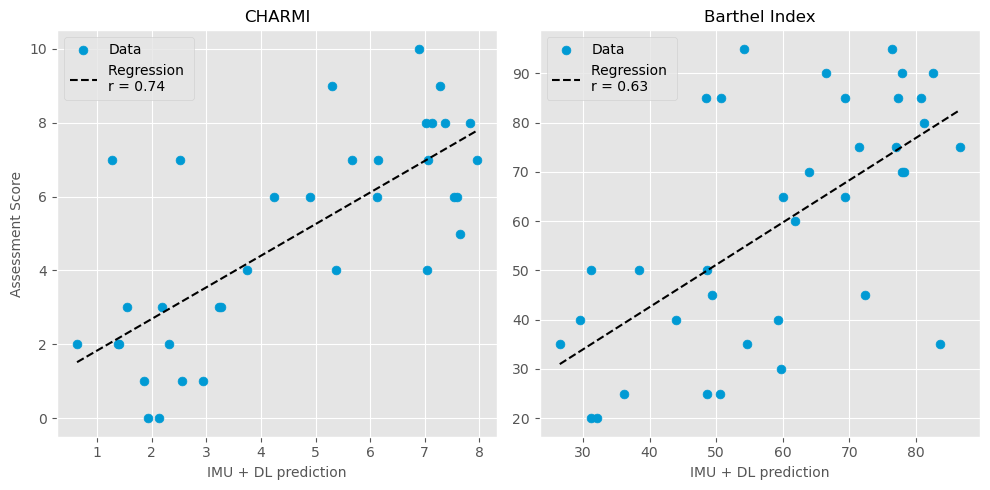

In [30]:
plt.style.use('ggplot')
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=False)
data = [
    (charmi_y_pred, charmi[charmi_assessment].values, "CHARMI"),
    (bi_y_pred, bi[bi_assessment].values, "Barthel Index")
]

for i, (x, y, title) in enumerate(data):
    ax = axes[i]
    ax.scatter(x, y, color='#009AD4', s=40, marker='o', label='Data')
    slope, intercept, r_value, p_value, _ = stats.linregress(x, y)
    print(p_value)
    line = slope * x + intercept
    ax.plot([min(x), max(x)], [min(line), max(line)], color='black', linestyle='--', label=f'Regression \nr = {r_value:.2f}')
    ax.set_xlabel('IMU + DL prediction', fontsize=10)
    ax.set_title(title, fontsize=12)
    ax.legend(loc='upper left')

axes[0].set_ylabel('Assessment Score', fontsize=10)
plt.tight_layout()

# plt.savefig('./IMU+DL_regression.png', dpi=400, bbox_inches='tight')
plt.show();

## Data Export

In [31]:
results = pd.concat([coc_table, charmi_table, bi_table], axis=1)
# results.round(4).to_csv('./results_IMU.csv')